# SISTER CWL submission
***

In [380]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython
from itertools import groupby
import datetime as dt 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

In [381]:
def get_quicklook(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0]
    return f'{granule}/{os.path.basename(granule)}.png'

### Load production list with scene URLs


In [36]:
scene_df = pd.read_csv('./sister_production_2_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Type,Area,Flight Line,Platform,l1_granule,Valid URL,Priority,Notes
117,DESIS,Validation,MOBY,DT0623620108_006-20210820T011554-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,LOW,MISSING VAL DATA
118,DESIS,Validation,La Crau RadCalNet,DT0729839672_002-20220606T114600-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
119,DESIS,Validation,Railroad Valley RadCalNet,DT0735007812_010-20220618T210853-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
120,DESIS,Validation,Gobabeb RadCalNet,DT2019020405_002-20190204T084554-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
121,DESIS,Terrestrial,UNDERC,DT0488344520_005-20200818T141910-V0210,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,LOW,NaN


### Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and a composite release identifier (crid) and returns a scene identifier along with a workflow configuration for the scene.

In [434]:
def gen_config(l1_granule,crid):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    landsat = 'None'   
    preprocess_queue = "sister-job_worker-16gb"
    segmentation_size = 50
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
                
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
        preprocess_queue = "sister-job_worker-32gb"
        
        #Run large Sierra scenes with larger segmentation size
        if ('f130612' in base_name) or ('f210326' in base_name):
            segmentation_size = 100

    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
        
    input_config =  [
    {
      "step_key": "l1_preprocess",
      "algorithm_id": "sister-preprocess",
      "version": "2.0.0",
      "queue": preprocess_queue,
      "params": {
        "raw_dataset": l1_granule,
        "landsat_dataset": landsat,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L1B_RDN_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
      "step_key": "l2_reflectance",
      "algorithm_id": "sister-isofit",
      "queue": "sister-job_worker-32gb",
      "version":"2.0.0",
      "input_filter": {
        "radiance_dataset":  f"*RDN*{crid}",
        "location_dataset": "*RDN*LOC",
        "observation_dataset": "*RDN*OBS",          
      },
      "params": {
        "radiance_dataset": None,
        "location_dataset": None,
        "observation_dataset": None,
        "n_cores": 32,
        "segmentation_size": segmentation_size,
        "crid": crid,
        "identifier": f"SISTER_{sensor}_L2A_RFL_{datetime}_{crid}",
        "username":"anonymous"
      },

    },
    {
      "step_key": "l2_resample",
      "algorithm_id": "sister-resample",
      "version":"2.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": f"*_RFL_*{crid}",
        "uncertainty_dataset": "*_RFL*UNC"

      },
      "params": {
        "reflectance_dataset": None,
        "uncertainty_dataset":None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_reflectance_correction",
      "algorithm_id": "sister-reflect_correct",
      "version":"2.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "observation_dataset": "*RDN*OBS",
        "reflectance_dataset": f"*RSRFL*{crid}"
      },
      "params": {
        "observation_dataset": None,
        "reflectance_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_CORFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_frcover",
      "algorithm_id": "sister-fractional-cover",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*"
      },
      "params": {
        "reflectance_dataset": None,
        "n_cores": 10,
        "refl_scale": 1,
        "normalization": 'brightness',
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_FRCOVER_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
        "step_key": "l2b_router",
        "algorithm_id": "sister-algorithm_router",
        "version": "1.0.0",
        "queue": "sister-job_worker-16gb",
        "input_filter": {
          "frcov_dataset": "*L2B_FRCOV*",
          "reflectance_dataset": "*CORFL*"
        },
        "params": {
          "frcov_dataset": None,
          "reflectance_dataset": None,
          "snow_cover": 0.9,
          "veg_cover": 0.5,
          "min_pixels": 100,
          "crid": crid,
          "identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "routed_pge_identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "username": "anonymous",
          "maap_api_host" : "sister-api-int.imgspec.org"
        }
      }     
  ]

    return sensor,datetime,json.dumps(input_config,indent=4)
    

### Generate single CWL workflow configuration

In [435]:
crid = 999
sensor,datetime,input_config = gen_config('https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/raw/PRS_L1_STD_OFFL_20201225185042_20201225185046_0001.zip',
                                    crid)
print(input_config)
print(sensor,datetime)

[
    {
        "step_key": "l1_preprocess",
        "algorithm_id": "sister-preprocess",
        "version": "2.0.0",
        "queue": "sister-job_worker-16gb",
        "params": {
            "raw_dataset": "https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/raw/PRS_L1_STD_OFFL_20201225185042_20201225185046_0001.zip",
            "landsat_dataset": "https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_20201225185042_20201225185046_0001_landsat.tar.gz",
            "crid": 999,
            "identifier": "SISTER_PRISMA_L1B_RDN_20201225T185042_999",
            "username": "anonymous"
        }
    },
    {
        "step_key": "l2_reflectance",
        "algorithm_id": "sister-isofit",
        "queue": "sister-job_worker-32gb",
        "version": "2.0.0",
        "input_filter": {
            "radiance_dataset": "*RDN*999",
            "location_dataset": "*RDN*LOC",
            "observation_dataset": "*RDN*OBS"
        },
        "params": {
  

### Submit single CWL workflow job

In [436]:
identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"

job_response = maap.submitJob(
       algo_id="run_sister_workflow",
       version="2.0",
       queue="sister-job_worker-8gb",
       identifier= identifier,
       username="anonymous",
       workflow_config=input_config)

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job_response.status )
print("    Submission status: %s" % job_response.id )


Submitted SISTER_PRISMA_CWL_20201225T185042_999 CWL worflow job
    Submission status: success
    Submission status: 40ab43fc-4262-491d-abe1-5e02e03aaa30


### Create list of granules to run and set CRID

In [317]:
crid = "001"
granules = scene_df[scene_df.Priority == 'HIGH'].l1_granule
print(f"{len(granules)} files in granule list")

20 files in granule list


### Loop through dataframe and start a CWL workflow for each each input scene 

In [ ]:
for l1_granule in granules[:0]:
    scene_name = os.path.basename(l1_granule)       
    sensor,datetime,input_config = gen_config(l1_granule,crid)
    identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"
    print(f"Submitting {identifier}")
    print(l1_granule)
    
    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow",
            version="2.0",
            queue="sister-job_worker-8gb",
            identifier=identifier,
            username="anonymous",
            workflow_config=input_config)
        print(f"\tSubmission status: {job.status}")

# Monitor jobs
***

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [446]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [447]:
crid= "001"
pattern = f"^SISTER.*{crid}$"

### Cycle through jobs and store job information for tags matching regex pattern

In [449]:
production = {}
crid= "001"

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]

    if re.match(pattern,tag):

        job_info = {}
        job_info['id'] = job_id
        job_info['status'] = job[job_id]['status'].replace('job-','')

        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'


        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        if tag not in production.keys():
            production[tag] = job_info

        elif job_info['start_time'] >  production[tag]['start_time']:
            production[tag] = job_info

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']
            else:
                instance_type = np.nan
        else:
            instance_type = np.nan

        job_info['instance_type'] = instance_type

        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])


        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage

### Group tags by tag datetimes and print statuses

In [450]:
tags = sorted( list(production.keys()), key=lambda x: x.split("_")[-2])

#Print only workflows with failed jobs
failed_only = True

for datetime, group in groupby(tags, lambda x: x.split("_")[-2]):
    group = [x for x in group]
    key ='_'.join(group[0].split('_')[:2])
    datetime = group[0].split('_')[-2]
    
    if failed_only:
        failed = 'failed' in [production[tag]['status'] for tag in group]
    else:
        failed = True
    
    if failed:
        print(f"{key}_*_{datetime}")

        for tag in group:
            status = production[tag]['status']
            if status == 'failed':
                status = f"\x1b[31m{status}\x1b[0m"
            elif status == 'completed':
                status = f"\x1b[34m{status}\x1b[0m"
            elif status == 'started':
                status = f"\x1b[32m{status}\x1b[0m"
            elif status == 'queued':
                status = f"\x1b[33m{status}\x1b[0m"

            print(f"\t {tag}")
            print(f"\t\t Job status: {status}")
            print(f"\t\t Job ID: {production[tag]['id']}")


SISTER_AVCL_*_20060426T010003
	 SISTER_AVCL_L1B_RDN_20060426T010003_001
		 Job status: completed
		 Job ID: 465fbcf1-04f7-4f20-834e-372cfd4cefb6
	 SISTER_AVCL_L2A_RFL_20060426T010003_001
		 Job status: failed
		 Job ID: f9e84f1a-ed26-4afb-a238-7881a89fb0ad
	 SISTER_AVCL_CWL_20060426T010003_001
		 Job status: failed
		 Job ID: 460557f8-6462-490b-bcc2-ed473a45ea90
SISTER_AVCL_*_20130612T010014
	 SISTER_AVCL_CWL_20130612T010014_001
		 Job status: failed
		 Job ID: 9fe29d30-93d1-492a-9d4e-7c4a54a22d69
	 SISTER_AVCL_L1B_RDN_20130612T010014_001
		 Job status: completed
		 Job ID: 93fa034a-f791-4a5d-90c7-560681a7ee47
	 SISTER_AVCL_L2A_RFL_20130612T010014_001
		 Job status: completed
		 Job ID: 2d05994d-6f09-4882-a576-81033a1c21d7
SISTER_PRISMA_*_20200727T104033
	 SISTER_PRISMA_L1B_RDN_20200727T104033_001
		 Job status: completed
		 Job ID: 991f76eb-6d5d-4956-8d9c-5a61db06534e
	 SISTER_PRISMA_L2A_RFL_20200727T104033_001
		 Job status: failed
		 Job ID: b57534eb-a5a4-4672-a49c-c5a584dbada1
	 SI

### Print full individual job info

In [439]:
job_info = production['SISTER_AVNG_L2A_RSRFL_20210429T185927_001']
job_info

{'id': 'c05166de-d184-4d05-8e4e-71e9ec51a4c6',
 'status': 'completed',
 'PGE': 'L2A_RSRFL',
 'sensor': 'AVNG',
 'start_time': datetime.datetime(2023, 2, 14, 23, 37, 21, 662623),
 'end_time': datetime.datetime(2023, 2, 14, 23, 37, 35, 597272),
 'duration': 0.0038707358333333335,
 'instance_type': 't3a.xlarge',
 'output_datasets': ['http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVNG/L2A_RSRFL/2021/04/29/SISTER_AVNG_L2A_RSRFL_20210429T190009_001',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVNG/L2A_RSRFL/2021/04/29/SISTER_AVNG_L2A_RSRFL_20210429T190009_001_UNC'],
 'input_datasets': ['s3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/LOM/PRODUCTS/AVNG/L2A_RFL/2021/04/29/SISTER_AVNG_L2A_RFL_20210429T190009_001',
  's3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/LOM/PRODUCTS/AVNG/L2A_RFL/2021/04/29/SISTER_AVNG_L2A_RFL_20210429T190009_001_UNC'],
 'inputs_disk_usage': 0.065759743,
 'staged_disk_usage': 0.03253666}

In [426]:
production

{'SISTER_AVNG_L2A_RFL_20220405T185108_001': {'id': '459ec647-8cd1-4fff-956c-8e69ee88da24',
  'status': 'completed',
  'PGE': 'L2A_RFL',
  'sensor': 'AVNG',
  'start_time': datetime.datetime(2023, 2, 14, 21, 48, 17, 551557),
  'end_time': datetime.datetime(2023, 2, 14, 22, 0, 10, 560420),
  'duration': 0.19805801750000002,
  'instance_type': 'c5.9xlarge',
  'output_datasets': ['http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVNG/L2A_RFL/2022/04/05/SISTER_AVNG_L2A_RFL_20220405T185138_001',
   'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVNG/L2A_RFL/2022/04/05/SISTER_AVNG_L2A_RFL_20220405T185138_001_UNC'],
  'input_datasets': ['s3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/LOM/PRODUCTS/AVNG/L1B_RDN/2022/04/05/SISTER_AVNG_L1B_RDN_20220405T185138_001',
   's3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/LOM/PRODUCTS/AVNG/L1B_RDN/2022/04/05/SISTER_AVNG_L1B_RDN_20220405T185138_001_LOC',
   's3://s3.us-west-2.amazo

# Display quicklook
***

### Use job ID to retrieve quicklook url and display

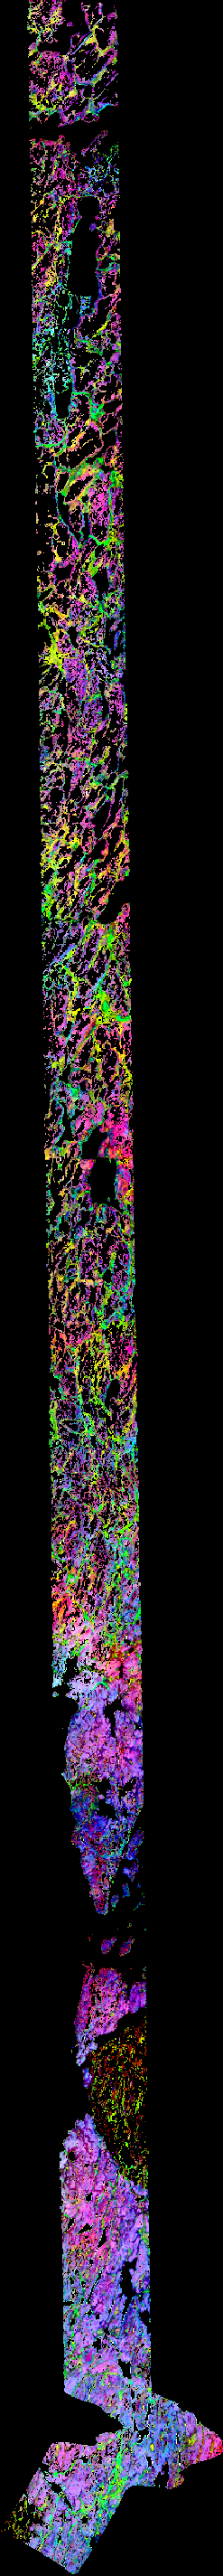

In [444]:
png = get_quicklook('abe5efc0-166d-451f-b67a-368aa6734c44')
IPython.display.Image(png)